In [1]:
# Add the parent directory to the path so that we can import the src module
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
from src.camera import CameraCalibration, Camera, CameraPose
from src.camera.video import VideoStream
from src.pose.position_estimation import PositionEstimation
from src.pingpong.ball import BallConstants
from src.pingpong.table import TableConstants
from src.fileutils import DATA_DIR

from tqdm import tqdm
import cv2
import matplotlib.pyplot as plt
import numpy as np
from ultralytics import YOLO

In [3]:
calibration_video = VideoStream(DATA_DIR / 'calibration' / 'Priyanshu_iPhone13.MOV')
calibration_images = list(tqdm(calibration_video))
calibration = CameraCalibration.from_calibration_video(tqdm(calibration_images))
calibration.intrinsic_matrix

0it [00:00, ?it/s]

866it [00:12, 69.45it/s]
100%|██████████| 866/866 [00:24<00:00, 35.11it/s]


array([[     1773.6,           0,      911.76],
       [          0,        2188,      544.32],
       [          0,           0,           1]])

In [4]:
camera = Camera(pose=None, calibration=calibration)
position_estimator = PositionEstimation(camera, BallConstants(), TableConstants())

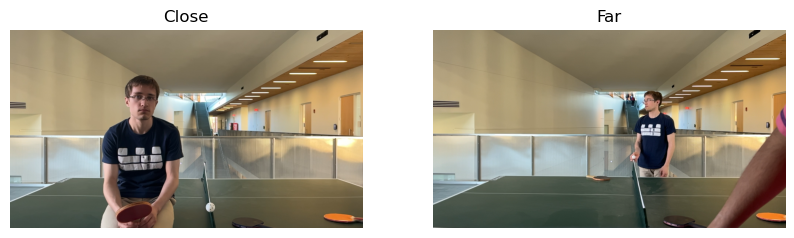

In [5]:
ping_pong_ball_close_image_path = DATA_DIR / 'calibration' / 'Priyanshu_iPhone13_Net_Close.png'
ping_pong_ball_far_image_path = DATA_DIR / 'calibration' / 'Priyanshu_iPhone13_Net_Far.png'

# Read images and plot on same plot
ping_pong_ball_close_image = cv2.imread(str(ping_pong_ball_close_image_path))
ping_pong_ball_far_image = cv2.imread(str(ping_pong_ball_far_image_path))

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(ping_pong_ball_close_image, cv2.COLOR_BGR2RGB))
plt.title('Close')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(ping_pong_ball_far_image, cv2.COLOR_BGR2RGB))
plt.title('Far')
plt.axis('off')

plt.show()


We know the length of the net. Therefore, we can test our calibration by checking estimates of the close and far ball positions.
In these images, the camera might not have been setup in precisely the same orientation. Therefore, we can expect to see some error.

4
1
1


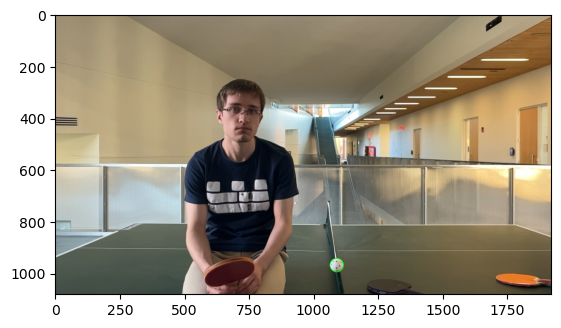

In [6]:
gray_image_close = cv2.cvtColor(ping_pong_ball_close_image, cv2.COLOR_BGR2GRAY)
augmented_image_close = cv2.cvtColor(ping_pong_ball_close_image, cv2.COLOR_BGR2RGB)

circles = cv2.HoughCircles(gray_image_close, cv2.HOUGH_GRADIENT, 1, 20, param1=50, param2=30, minRadius=10, maxRadius=30)
circles = np.uint16(np.around(circles))[0]

def filter_circles_by_brightness(circles, image, pixel_threshold, percentage_threshold):
    """ Filters out circle's based on the brightness of the pixels in the circle.
        If less than percentage_threshold of the pixels in the circle are brighter than pixel_threshold, the circle is not included.
    """
    filtered_circles = []
    for circle in circles:

        x, y, r = circle
        roi = image[y-r:y+r, x-r:x+r]
        bright_percentage = np.sum(roi > pixel_threshold) / roi.size
        if bright_percentage > percentage_threshold:
            filtered_circles.append(circle)

    return np.array(filtered_circles)

print(len(circles))
filtered_circles = filter_circles_by_brightness(circles, gray_image_close, 180, 0.3)
print(len(filtered_circles))
filtered_circles = filter_circles_by_brightness(filtered_circles, gray_image_close, 100, 0.5)
print(len(filtered_circles))

if len(filtered_circles) > 0:
    for i in range(len(filtered_circles)):

        center = (filtered_circles[i, 0], filtered_circles[i, 1])
        radius = filtered_circles[i, 2]

        # Draw the outer circle
        cv2.circle(augmented_image_close, center, radius, (0, 255, 0), 2)

    plt.imshow(augmented_image_close)
else:
    print('No ping pong ball detected')

In [7]:
ping_pong_ball = filtered_circles[0]
ping_pong_ball_center_x = ping_pong_ball[0]
ping_pong_ball_center_y = ping_pong_ball[1]
ping_pong_ball_radius = ping_pong_ball[2]

print(f'Center: ({ping_pong_ball_center_x}, {ping_pong_ball_center_y}), Radius: {ping_pong_ball_radius}')
print(f'Ball True Radius: {BallConstants().diameter/2}')

ball_position_close = position_estimator.ball_position_camera_reference_frame(ping_pong_ball_center_x, ping_pong_ball_center_y, ping_pong_ball_radius * 2)
ball_position_close


Center: (1090, 968), Radius: 26
Ball True Radius: 0.02


array([    0.13711,     0.26418,      1.3643])

32
7
6
6


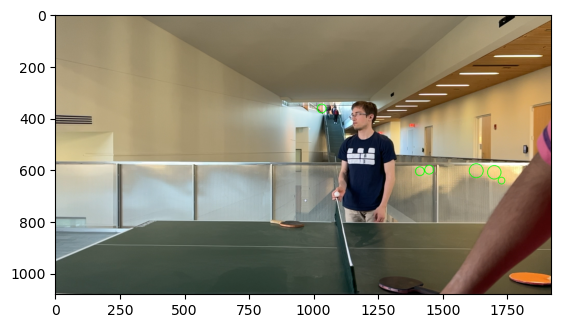

In [8]:
gray_image_far = cv2.cvtColor(ping_pong_ball_far_image, cv2.COLOR_BGR2GRAY)
augmented_image_far = cv2.cvtColor(ping_pong_ball_far_image, cv2.COLOR_BGR2RGB)

circles = cv2.HoughCircles(gray_image_far, cv2.HOUGH_GRADIENT, 1, 20, param1=50, param2=30, minRadius=5, maxRadius=30)
if circles is None:
    raise ValueError('No circles detected')

circles = np.uint16(np.around(circles))[0]
print(len(circles))
filtered_circles = filter_circles_by_brightness(circles, gray_image_far, 200, 0.3)
print(len(filtered_circles))
filtered_circles = filter_circles_by_brightness(filtered_circles, gray_image_far, 150, 0.5)
print(len(filtered_circles))
filtered_circles = filter_circles_by_brightness(filtered_circles, gray_image_far, 100, 0.5)
print(len(filtered_circles))


if len(filtered_circles) > 0:
    for i in range(len(filtered_circles)):

        center = (filtered_circles[i, 0], filtered_circles[i, 1])
        radius = filtered_circles[i, 2]

        # Draw the outer circle
        cv2.circle(augmented_image_far, center, radius, (0, 255, 0), 2)

    plt.imshow(augmented_image_far)
else:
    print('No ping pong ball detected')